In [1]:
"""
    INDEX FOR FINAL SUBMISSION:
    
    cells
    [2]: read the data / import data 'management' libraries
    [3]: read data_info.txt to be able to navigate data exploration
    [4-6]: transfer text into KEY-VALUE struct, KEY as data_info keys / data_values respectively
        with VALUE definitions; visualize
    [7-11]: detect & re cast as categorical those pandas read as integer
    [12-14]: detect which columns were actually not part of data_info
    [15-33]: exploring nan null with some options for how to deal with missing data
    [34-39]: extracting test set keys and comparing training sets 1 and 2
    [40-46]: closer look at Feature Price which seems to be target of training set 2
    [47-55]: minimal (incomplete) checks for merging training sets 1 and 2 (though by inspection not total match)
    [56-76]: clustering keys (almost entirely)
    [77-91]: removing nans
    [92-99]: primarily adding month incrementals to the year of sale column - also standardizing by "offset" centering
    [100-105]: descriptions of each data frame as considered standard for numerical vs. categorical (obj columns)
    [106-112]: final checks INCLUDING
        containing any string other than 'NA' to indicate nan (and completely 0 out panda's isna calls):
        containing string 'None', replaced with 'NA'
    [113]: HISTOGRAM OF PRICES (DISTRIBUTION)
    [114-123]: discovering most highly correlated "features" / columns
    [124-142]: PLOTTING QUANTILES AND EXTREMA FOR CATEGORICAL (also Price to LogPrice)
    [143]: RECASTING CATEGORICAL (OBJECT TYPES IN PANDAS DATAFRAMES) AS INTEGER / ORDINAL
    [144-154]: MUTUAL INFO* REGRESSION (UNIVARIATES): top positive values (> correlation threshold) corroborate
        previous correlations
    [155-159]: repeat *M.I. for just categoricals
    [160-162]: making sure column key/names (still) "add up"
    [163-164]: ACK would be mixed effects and recalling independent variables to model
    [165]: WRITE PROCESSED DATA TO CSV FOR STATISTICS WITH R
    [166-171]: Test Pinball-loss univariates Quantile regression (good for Spread/conditionals data)
        and Robust regression TheilSenRegressor (for multiple combinations.. & plot case by case)

"""
7

7

In [2]:
import pandas as pd
import pprint

df0 = pd.read_csv('./latlongs.csv')
df1 = pd.read_csv('./train_1.csv')
df2 = pd.read_csv('./train_2.csv')

"""
    SUMMARY OF ACTIONS TAKEN:

    * GET EXPECTED NUMERICAL VS CATEGORICAL FROM DATA_INFO TXT
    * REVERT NUMERICAL WHICH MUST BE CATEGORICAL
    * SEPARATE NUMERIC FROM OBJECT (CATEGORICAL DATA) COLUMNS INTO TWO DF (PRESERVING ROW..)
    * INTERPRET NA / NAN & PROCESS / PREPARE DATA FOR TRANSFORMATION / MODELING :
    * EXTRACT "Y" PREDICTED / DEPENDENT VARIABLE COLUMNS
\

"""
1

1

In [3]:
"""
    The typo in data_info.txt has been fixed: "3SeasonnPorchArea" (else fixing in code)
    
    1. Split whole text on EMPTY Lines
    2. Filter out empty lines from ingestion into list
    3. Strip empty lines from newline-breaks but keep white space
"""

info = [m.strip('\n') for m in open('./data_info.txt', 'r').read().split('\n\n')
        if m not in ('', '\n')]
for m in info:
    print(m)

Dataset Metadata
BuildType: Identifies the type of sold building.
        20	1-STORY >=1946
        30	1-STORY <1946
        40	1-STORY WITH ATTIC
        45	1.5 STORY UNFINISHED
        50	1.5 STORY FINISHED
        60	2-STORY >=1946
        70	2-STORY <1946
        75	2.5 STORY
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX
       120	1-STORY PUD (Planned Unit Development) >=1946
       150	1.5 STORY PUD
       160	2-STORY PUD >=1946
       180	PUD - MULTILEVEL
       190	2 FAMILY CONVERSION
Zone: Identifies the general zoning classification of the sale.
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park
       RM	Residential Medium Density
StreetLength: Linear feet of street connected to property
Area: Area of property in square feet
RoadType: Type of road access to property
       Grvl	Gravel
       Pa

In [4]:
"""
    Separate keys (columns names) from their values (categorical only).

    Values are always multiples (otherwise trivial)
    and indented in the original text.

    Values and each of their definitions are tab separated:
    Make sure to further strip white spaces.
"""

keys = {}
last_key = None
values = {}
for i in range(1, len(info)):
    s = info[i].split('\n')  # multiples of the values (if)
    if len(s) == 1:
        s = s[0]
        s1, s2 = s.split(': ')
        s1 = s1.strip()
        if s1 == '3SeasonnPorchArea':  # fix mistake
            s1 = '3SeasonPorchArea'
        s2 = s2.strip()
        assert(s1 not in keys)
        keys[s1] = s2
        last_key = s1
        continue
    assert(last_key is not None)
    assert(last_key not in values)
    values[last_key] = [ss.strip().split('\t') for ss in s]

for k,v in values.items():  # Recognize!
    for vv in v:
        if len(vv) != 2:
            print(k, len(vv), vv)
    
for k,v in values.items():
    if k=='County': continue  #
    values[k] = [(vv[0].strip(), vv[1].strip()) for vv in v]

County 1 ['Newham Wiltshire']


In [5]:
pprint.pprint(values)

{'AC': [('N', 'No'), ('Y', 'Yes')],
 'AlleyType': [('Grvl', 'Gravel'),
               ('Pave', 'Paved'),
               ('NA', 'No alley access')],
 'BaseCondition': [('Ex', 'Excellent'),
                   ('Gd', 'Good'),
                   ('TA', 'Typical - slight dampness allowed'),
                   ('Fa', 'Fair - dampness or some cracking or settling'),
                   ('Po', 'Poor - Severe cracking, settling, or wetness'),
                   ('NA', 'No Basement')],
 'BaseHeight': [('Ex', 'Excellent (100+ inches)'),
                ('Gd', 'Good (90-99 inches)'),
                ('TA', 'Typical (80-89 inches)'),
                ('Fa', 'Fair (70-79 inches)'),
                ('Po', 'Poor (<70 inches'),
                ('NA', 'No Basement')],
 'BuildType': [('20', '1-STORY >=1946'),
               ('30', '1-STORY <1946'),
               ('40', '1-STORY WITH ATTIC'),
               ('45', '1.5 STORY UNFINISHED'),
               ('50', '1.5 STORY FINISHED'),
               ('60', '

In [6]:
numerical = keys.keys() - values.keys()
print(len(numerical), sorted(numerical))

30 ['3SeasonPorchArea', 'AGroundArea', 'AGroundBedroom', 'AGroundKitchens', 'AGroundRooms', 'Area', 'Area1', 'Area2', 'BaseArea', 'BaseBath', 'BaseHalfBath', 'BuildYear', 'EnclosedPorchArea', 'FeaturePrice', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageBuildYear', 'GarageCars', 'HBath', 'LQArea', 'OpenPorchArea', 'PoolArea', 'RefurbishYear', 'SaleMonth', 'SaleYear', 'ScreenPorchArea', 'StreetLength', 'VeneerArea', 'WoodDeckArea']


In [7]:
df1_description = df1.describe()  # statistical percentiles
df2_description = df2.describe()  # filters for numerical columns
print('df1_description')
for c in df1_description.columns:
    if c in values:
        print('    A categorical interpreted numerically:')
    if c not in numerical or c not in keys:
        print('  Info values:', c in values, '/ Info key:', c in keys, '/', c)
print('df2_description')
for c in df2_description.columns:
    if c in values:
        print('    A categorical interpreted numerically:')
    if c not in numerical or c not in keys:
        print('  Info values:', c in values, '/ Info key:', c in keys, '/', c)

df1_description
    A categorical interpreted numerically:
  Info values: True / Info key: True / BuildType
  Info values: False / Info key: False / BaseHBath
  Info values: False / Info key: False / Price
df2_description
  Info values: False / Info key: False / Id
    A categorical interpreted numerically:
  Info values: True / Info key: True / BuildType
    A categorical interpreted numerically:
  Info values: True / Info key: True / Condition


In [8]:
"""
    BaseHBath would have been BaseHalfBath (number of "rooms")
    
    Price is the dependent or predicted variable (not to be confused with FeaturePrice* see exploration later/below)
    
    ID is "table" specific and not generally in data_info.txt
"""
0

0

In [9]:
print(df1['BuildType'].isna().any())
print(df2['BuildType'].isna().any())
print(df2['Condition'].isna().any())

False
False
False


In [10]:
print(df1['BuildType'].unique())
print(df2['BuildType'].unique())
print(df2['Condition'].unique())

[ 90  30 160  80  20  60  50  70 190 120  85  45  75  40 180]
[ 20 190  80  50 120 160  70  30  60  75  45  90  40 180  85]
[7 5 4 8 6 9 3 2 1]


In [11]:
"""
    Convert misinterpreted numerically to categorical!

"""
df1['BuildType'] = df1['BuildType'].astype(str)
df2['BuildType'] = df2['BuildType'].astype(str)
df2['Condition'] = df2['Condition'].astype(str)

In [12]:
print(set([df1[column].dtype for column in df1]))
print(set([df2[column].dtype for column in df2]))

{dtype('O'), dtype('int64'), dtype('float64')}
{dtype('O'), dtype('int64'), dtype('float64')}


In [13]:
"""
    NA = not available; should be interpreted separately from nan
    (So should None)
"""
NA_is_val = [k for k,v in values.items() if 'NA' in [vv[0] for vv in v]]
len(NA_is_val), NA_is_val

(10,
 ['AlleyType',
  'BaseHeight',
  'BaseCondition',
  'FireplaceQuality',
  'GarageType',
  'GarageFinish',
  'GarageCondition',
  'PoolQuality',
  'FenceQuality',
  'OtherFeature'])

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf1 = df1.select_dtypes(include=numerics)
newdf2 = df2.select_dtypes(include=numerics)
odf1 = df1.select_dtypes(include=object)
odf2 = df2.select_dtypes(include=object)

"""
    This we knew already:
"""
for s in set(newdf1.columns):
    if s not in numerical:
        print(s, s in numerical)
print()
for s in set(newdf2.columns):
    if s not in numerical:
        print(s, s in numerical)

BaseHBath False
Price False

Id False


In [15]:
"""
    Dealing with nan, None or "null"...

"""
print(df1.isna().any().sum())
print(df1.isnull().any().sum())
print(df2.isna().any().sum())
print(df2.isnull().any().sum())

9
9
10
10


In [16]:
"""
    Strategies:
    -
    If numerical, put median / put extrema (inf, 0, -inf) / drop whole column vs. row?
    If categorical: put 'UNKNOWN' unless 'NA'

"""
na1 = df1.columns[df1.isna().any()]
na2 = df2.columns[df2.isna().any()]
NA_is_val = set(NA_is_val)
num_na1 = set(na1) & numerical
num_na2 = set(na2) & numerical
cat_na1 = set(na1) - num_na1
cat_na2 = set(na2) - num_na2
print('T? \ [Numeric] \ [Categorical]:\n')
print('T1\n', sorted(num_na1), '\n', sorted(cat_na1))
print('T2\n', sorted(num_na2), '\n', sorted(cat_na2))
print('\nin both (categorical)')
print(sorted(cat_na1&cat_na2))
print()
in1 = cat_na1&NA_is_val
in2 = cat_na2&NA_is_val
print('T1 ~ unknown\n', sorted(cat_na1-in1))
print('T1 ~ unknown | NA\n', sorted(in1))
print('T2 ~ unknown\n', sorted(cat_na2-in2))
print('T2 ~ unknown | NA\n', sorted(in2))

T? \ [Numeric] \ [Categorical]:

T1
 ['GarageBuildYear', 'StreetLength'] 
 ['AlleyType', 'Electrical', 'FenceQuality', 'GarageType', 'PoolQuality', 'RoofMat', 'VeneerType']
T2
 ['VeneerArea'] 
 ['BaseCondition', 'BaseHeight', 'County', 'Electrical', 'FireplaceQuality', 'GarageCondition', 'GarageFinish', 'OtherFeature', 'RoofMat']

in both (categorical)
['Electrical', 'RoofMat']

T1 ~ unknown
 ['Electrical', 'RoofMat', 'VeneerType']
T1 ~ unknown | NA
 ['AlleyType', 'FenceQuality', 'GarageType', 'PoolQuality']
T2 ~ unknown
 ['County', 'Electrical', 'RoofMat']
T2 ~ unknown | NA
 ['BaseCondition', 'BaseHeight', 'FireplaceQuality', 'GarageCondition', 'GarageFinish', 'OtherFeature']


In [17]:
"""
    Categories for which entity does not necessarily exist (for row/sales property)
    % nan
"""
df1[cat_na1 & NA_is_val].isna().sum()/df1.shape[0]*100

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/33447538.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1[cat_na1 & NA_is_val].isna().sum()/df1.shape[0]*100


FenceQuality    80.753425
AlleyType       93.767123
PoolQuality     99.520548
GarageType       5.547945
dtype: float64

In [18]:
"""
    Categories for which entity does not necessarily exist (ie has NA)
    Notice: GarageType in df1 also has 5.547945%
    Notice: BaseHeight == BaseCondition
    
    % nan
"""
df2[cat_na2 & NA_is_val].isna().sum()/df2.shape[0]*100

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/1675654334.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df2[cat_na2 & NA_is_val].isna().sum()/df2.shape[0]*100


OtherFeature        96.301370
BaseHeight           2.534247
GarageFinish         5.547945
BaseCondition        2.534247
FireplaceQuality    47.260274
GarageCondition      5.547945
dtype: float64

In [19]:
"""
    DECISION (where NA_is_val): Replace nan with 'NA' category everywhere
"""
0

0

In [20]:
"""
    Categories for which entity is essential (therefore truly missing "in data" not in real life)
    
    Actually, VeneerType has None, should belong with NA
    
    % nan
"""

df1[cat_na1-(cat_na1&NA_is_val)].isna().sum()/df1.shape[0]*100


/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/1975405968.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1[cat_na1-(cat_na1&NA_is_val)].isna().sum()/df1.shape[0]*100


Electrical    32.397260
RoofMat       39.383562
VeneerType     0.547945
dtype: float64

In [21]:
"""
    Categories for which entity is essential
    
    Veneer only in df1
    Notice:  RoofMat in df1 and df2 not equal but very close
    
    % nan
"""

df2[cat_na2-(cat_na2&NA_is_val)].isna().sum()/df2.shape[0]*100

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/2994047103.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df2[cat_na2-(cat_na2&NA_is_val)].isna().sum()/df2.shape[0]*100


Electrical    19.657534
RoofMat       39.589041
County         1.164384
dtype: float64

In [22]:
"""
    DECISION: Either treat Veneer as "optional" category (has NA), or decide drop finally after further analysis.
        Electrical has "Mix" mixed value which isn't necessarily indicative of quality, though might be :\
        RoofMat would be given additional 'UNKNOWN' category, as the others might be signal.
"""
0

0

In [23]:
"""
    Neither necessarily exist /
    
    Notice: GarageType in df1 also has 5.547945%
    Notice: GarageFinish in df2 also has 5.547945%
    Notice: GarageCondition in df2 also has 5.547945%
"""
df1[num_na1].isna().sum()/df1.shape[0]*100

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/1857865273.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1[num_na1].isna().sum()/df1.shape[0]*100


StreetLength       17.739726
GarageBuildYear     5.547945
dtype: float64

In [24]:
"""
    Count? ( vs. percentage
"""
df1[num_na1].isna().sum()

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/1580559850.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1[num_na1].isna().sum()


StreetLength       259
GarageBuildYear     81
dtype: int64

In [25]:
df1['GarageBuildYear'].value_counts()  # PUT -INFINITY? since indicates "vanishing" value

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1933.0     1
1906.0     1
1908.0     1
1927.0     1
1900.0     1
Name: GarageBuildYear, Length: 97, dtype: int64

In [26]:
"""
    Missing Veneer area values implies no Veneer or 0 area (unless 0 is actually in data):
"""
df2[num_na2].isna().sum()/df2.shape[0]*100

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/3459525322.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df2[num_na2].isna().sum()/df2.shape[0]*100


VeneerArea    0.547945
dtype: float64

In [27]:
df2['VeneerArea'].value_counts()  # Implies missingness cannot be defined as 0:  DROP ROWS?

0.0      861
108.0      8
180.0      8
72.0       8
120.0      7
        ... 
278.0      1
123.0      1
297.0      1
296.0      1
11.0       1
Name: VeneerArea, Length: 327, dtype: int64

In [28]:
"""
    Notice: df2.VeneerArea.nan% == df1.VeneerType.nan% missingness!

    What would this imply on df2 ~ df1: What would be VeneerType for 0 Area ?

    Either missingness is intentional (meaning category and value UNKNOWN)
        or value is also 0 but unspecified -
"""
0
"""
    Nearest neighbor (or manifold learning) might help to infer missing data!
    
    (out of scope)
"""
0

0

In [29]:
print(df2[num_na2].isna().sum())  # HOW MANY ROWS WITH MISSING (NUMERICAL) ?

VeneerArea    8
dtype: int64


/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/1004680283.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(df2[num_na2].isna().sum())  # HOW MANY ROWS WITH MISSING (NUMERICAL) ?


In [30]:
df1['VeneerType'].isna().sum(), 'VeneerArea' in df1.columns

(8, False)

In [31]:
df1['VeneerType'].value_counts()  # DOES NOT COUNT THE 8 NAN

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: VeneerType, dtype: int64

In [32]:
df1['Price'][df1['VeneerType'].isna()]  # WHAT COULD THOSE BE? (are they in/out of distribution?)

93      182000.0
290     199900.0
480     205950.0
670     465000.0
719     200624.0
738     237000.0
1366    216500.0
1382    184900.0
Name: Price, dtype: float64

In [33]:
df2['FeaturePrice'][df2['VeneerArea'].isna()]

71      0
159     0
352     0
379     0
615     0
709     0
1014    0
1021    0
Name: FeaturePrice, dtype: int64

In [34]:
"""
    Reminder
"""

print(df1.shape, df2.shape)

(1460, 41) (1460, 37)


In [35]:
keys

{'BuildType': 'Identifies the type of sold building.',
 'Zone': 'Identifies the general zoning classification of the sale.',
 'StreetLength': 'Linear feet of street connected to property',
 'Area': 'Area of property in square feet',
 'RoadType': 'Type of road access to property',
 'AlleyType': 'Type of alley access to property',
 'Shape': 'General shape of property',
 'LandContour': 'Flatness of the property',
 'Utilities': 'Type of utilities available',
 'Configuration': 'Property configuration',
 'LandSlope': 'Slope of property',
 'County': 'Physical locations within Ames city limits',
 'Feature1': 'Proximity to various conditions',
 'Feature2': 'Proximity to various conditions (if more than one is present)',
 'Type': 'Type of property',
 'Style': 'Style of property',
 'Condition': 'Rates the overall condition of the house',
 'BuildYear': 'Original construction date',
 'RefurbishYear': 'Date of refurbishment (same as construction date if no remodeling or additions)',
 'RoofType': 'Ty

In [36]:
y_keys = { 'FeaturePrice': '$Value of miscellaneous feature',
 'SaleMonth': 'Month Sold (MM)',
 'SaleYear': 'Year Sold (YYYY)',
 'SaleType': 'Type of sale',
 'SaleCondition': 'Condition of sale'}

common = set(df1.columns) & set(df2.columns)

In [37]:
for column in df1.columns:
    if column not in keys:
        print('{', column, '}')
print(' / '.join(sorted(df1.columns)))

{ BaseHBath }
{ Price }
AC / AGroundArea / AGroundBedroom / AGroundKitchens / AlleyType / Area / Area1 / Area2 / BaseBath / BaseHBath / BuildType / BuildYear / DriveSurface / Electrical / ExteriorCondition / Feature1 / FenceQuality / Fireplaces / Foundation / Functionality / GarageArea / GarageBuildYear / GarageCars / GarageType / HBath / HeatingType / KitchenQuality / PoolArea / PoolQuality / Price / RefurbishYear / RoofMat / RoofType / SaleMonth / SaleType / SaleYear / Shape / StreetLength / Style / Type / VeneerType


In [38]:
for column in df2.columns:
    if column not in keys:
        print('{', column, '}')
print(' / '.join(sorted(df2.columns)))

{ Id }
3SeasonPorchArea / AGroundRooms / Area / BaseArea / BaseCondition / BaseHeight / BuildType / Condition / Configuration / County / Electrical / EnclosedPorchArea / ExteriorMat / Feature2 / FeaturePrice / FireplaceQuality / FullBath / GarageCondition / GarageFinish / HeatingQuality / Id / LQArea / LandContour / LandSlope / OpenPorchArea / OtherFeature / PoolArea / RefurbishYear / RoadType / RoofMat / RoofType / SaleCondition / ScreenPorchArea / Utilities / VeneerArea / WoodDeckArea / Zone


In [39]:
common

{'Area',
 'BuildType',
 'Electrical',
 'PoolArea',
 'RefurbishYear',
 'RoofMat',
 'RoofType'}

In [40]:
"""
    PREDICTIVE TASK (DATA EXPLORATION)
    
    
    DF2 DOES NOT CONTAIN OTHER "PRICE"/Sales SPECIFIC DATA (except for FeaturePrice )

"""
print(keys['SaleCondition'])
print(values['SaleCondition'])

Condition of sale
[('Normal', 'Normal Sale'), ('Abnorml', 'Abnormal Sale -  trade, foreclosure, short sale'), ('AdjLand', 'Adjoining Land Purchase'), ('Alloca', 'Allocation - two linked properties with separate deeds, typically condo with a garage unit'), ('Family', 'Sale between family members'), ('Partial', 'Home was not completed when last assessed (associated with New Homes)')]


In [41]:
"""
    Is Feature1 price specific?
"""
print(keys['Feature1'])
print(values['Feature1'])

Proximity to various conditions
[('Artery', 'Adjacent to arterial street'), ('Feedr', 'Adjacent to feeder street'), ('Norm', 'Normal'), ('RRNn', "Within 200' of North-South Railroad"), ('RRAn', 'Adjacent to North-South Railroad'), ('PosN', 'Near positive off-site feature--park, greenbelt, etc.'), ('PosA', 'Adjacent to postive off-site feature'), ('RRNe', "Within 200' of East-West Railroad"), ('RRAe', 'Adjacent to East-West Railroad')]


In [42]:
"""
    Is Feature2 price specific?
"""
print(keys['Feature2'])
print(values['Feature2'])

Proximity to various conditions (if more than one is present)
[('Artery', 'Adjacent to arterial street'), ('Feedr', 'Adjacent to feeder street'), ('Norm', 'Normal'), ('RRNn', "Within 200' of North-South Railroad"), ('RRAn', 'Adjacent to North-South Railroad'), ('PosN', 'Near positive off-site feature--park, greenbelt, etc.'), ('PosA', 'Adjacent to postive off-site feature'), ('RRNe', "Within 200' of East-West Railroad"), ('RRAe', 'Adjacent to East-West Railroad')]


In [43]:
df2_description['FeaturePrice']

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: FeaturePrice, dtype: float64

In [44]:
"""
    Shows why 75% is also at 0.000000
"""
df2['FeaturePrice'].value_counts()

0        1408
400        11
500         8
700         5
2000        4
450         4
600         4
480         2
1200        2
560         1
15500       1
800         1
350         1
1400        1
1300        1
8300        1
1150        1
2500        1
54          1
3500        1
620         1
Name: FeaturePrice, dtype: int64

In [45]:
"""
    DISCOVERY:   FEATURE PRICE & OTHER FEATURE

"""
num_FeaturePrice_is_zero = 1408
df2.shape[0] - num_FeaturePrice_is_zero, df2['OtherFeature'].value_counts()  # EQUALS excluding "Othr"

(52,
 Shed    49
 Gar2     2
 Othr     2
 TenC     1
 Name: OtherFeature, dtype: int64)

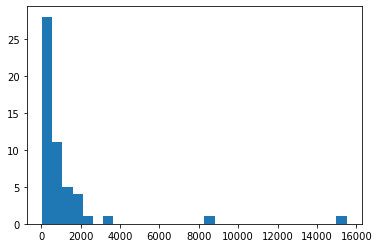

In [46]:
from matplotlib import pyplot as plt
plt.hist(df2['FeaturePrice'][df2['FeaturePrice'] > 0], bins=30)
plt.show()

In [47]:
"""
    PREDICTIVE TASK (DATA EXPLORATION)
    
    COULD WE RELATE DF2 TO DF1 ? MERGE ?
    
"""
df2['Id']

0        195
1       1268
2       1145
3        794
4        246
        ... 
1455    1255
1456     803
1457    1459
1458     140
1459    1195
Name: Id, Length: 1460, dtype: int64

In [48]:
# is not sorted, yet :

list(sorted(df2['Id'])) == list(range(1, 1 + df2.shape[0]))

True

In [49]:
"""
    Check if re-sort Id makes common columns correspond in df2 to df1
    
"""
h = list(sorted(list(zip(df2['Id'].values-1, range(df2.shape[0])))))
z = [hh[1] for hh in h]

In [50]:
df2 = df2.reindex(z).set_index('Id')

In [51]:
print(df1[common].sort_values(['RefurbishYear', 'BuildType', 'Area', 'PoolArea', 'Electrical', 'RoofType', 'RoofMat']).head(50))
print(df2[common].sort_values(['RefurbishYear', 'BuildType', 'Area', 'PoolArea', 'Electrical', 'RoofType', 'RoofMat']).head(50))

     RoofType  RefurbishYear  PoolArea Electrical BuildType   Area  RoofMat
1384        0           1950         0      SBrkr       190   5600  CompShg
1173    Gable           1950         0      SBrkr       190   7420      NaN
645         0           1950         0        NaN       190   7800  CompShg
603         0           1950         0      FuseP       190   9142  CompShg
173       Hip           1950         0      FuseF       190  10120  CompShg
283         0           1950         0      SBrkr       190  10880  CompShg
926         0           1950         0      SBrkr       190  11340      NaN
371         0           1950         0        NaN       190  12180      NaN
135     Gable           1950         0        NaN       190  13600  CompShg
1132    Gable           1950         0      FuseF        20   5000  CompShg
58          0           1950         0        NaN        20   6000  CompShg
484       Hip           1950         0      SBrkr        20   6627      NaN
634     Gabl

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/977905378.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(df1[common].sort_values(['RefurbishYear', 'BuildType', 'Area', 'PoolArea', 'Electrical', 'RoofType', 'RoofMat']).head(50))
/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/977905378.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(df2[common].sort_values(['RefurbishYear', 'BuildType', 'Area', 'PoolArea', 'Electrical', 'RoofType', 'RoofMat']).head(50))


In [52]:
# Why is there a 0 RoofType ?
df1['RoofType'][df1['RoofType']=='0'].value_counts()

0    440
Name: RoofType, dtype: int64

In [53]:
df1['RoofType'].isna().sum()

0

In [54]:
# ?
df2['RoofType'][df2['RoofType']=='0']

Series([], Name: RoofType, dtype: object)

In [55]:
"""
    Indexes do not seem to correspond =/> TRY hash or "neirest neighbors" / de-duplication  strategies...)

"""
0

0

In [56]:
len(odf1.columns), odf1.columns

(21,
 Index(['BuildType', 'Electrical', 'ExteriorCondition', 'AlleyType', 'RoofType',
        'RoofMat', 'Style', 'DriveSurface', 'Foundation', 'SaleType',
        'HeatingType', 'PoolQuality', 'AC', 'GarageType', 'VeneerType',
        'FenceQuality', 'Feature1', 'Functionality', 'KitchenQuality', 'Shape',
        'Type'],
       dtype='object'))

In [57]:
len(odf2.columns), odf2.columns

(22,
 Index(['BuildType', 'Zone', 'RoadType', 'LandContour', 'Utilities',
        'Configuration', 'LandSlope', 'County', 'Feature2', 'Condition',
        'RoofType', 'RoofMat', 'ExteriorMat', 'BaseHeight', 'BaseCondition',
        'HeatingQuality', 'Electrical', 'FireplaceQuality', 'GarageFinish',
        'GarageCondition', 'OtherFeature', 'SaleCondition'],
       dtype='object'))

In [58]:
len(newdf1.columns), newdf1.columns

(20,
 Index(['Area', 'RefurbishYear', 'PoolArea', 'Area1', 'GarageCars', 'SaleYear',
        'Fireplaces', 'StreetLength', 'AGroundKitchens', 'BuildYear',
        'AGroundBedroom', 'HBath', 'Area2', 'GarageArea', 'SaleMonth',
        'BaseBath', 'GarageBuildYear', 'AGroundArea', 'BaseHBath', 'Price'],
       dtype='object'))

In [59]:
len(newdf2.columns), newdf2.columns

(15,
 Index(['Id', 'Area', 'RefurbishYear', 'VeneerArea', 'BaseArea', 'LQArea',
        'FullBath', 'AGroundRooms', 'WoodDeckArea', 'OpenPorchArea',
        'EnclosedPorchArea', '3SeasonPorchArea', 'ScreenPorchArea', 'PoolArea',
        'FeaturePrice'],
       dtype='object'))

In [60]:
keys

{'BuildType': 'Identifies the type of sold building.',
 'Zone': 'Identifies the general zoning classification of the sale.',
 'StreetLength': 'Linear feet of street connected to property',
 'Area': 'Area of property in square feet',
 'RoadType': 'Type of road access to property',
 'AlleyType': 'Type of alley access to property',
 'Shape': 'General shape of property',
 'LandContour': 'Flatness of the property',
 'Utilities': 'Type of utilities available',
 'Configuration': 'Property configuration',
 'LandSlope': 'Slope of property',
 'County': 'Physical locations within Ames city limits',
 'Feature1': 'Proximity to various conditions',
 'Feature2': 'Proximity to various conditions (if more than one is present)',
 'Type': 'Type of property',
 'Style': 'Style of property',
 'Condition': 'Rates the overall condition of the house',
 'BuildYear': 'Original construction date',
 'RefurbishYear': 'Date of refurbishment (same as construction date if no remodeling or additions)',
 'RoofType': 'Ty

In [61]:
keys_area = set([k for k in keys if 'area' in k.lower()])
keys_type = set([k for k in keys if 'type' in k.lower()])
keys_year = set([k for k in keys if 'year' in k.lower()])
keys_condition = set([k for k in keys if 'condition' in k.lower()])
keys_sale = set([k for k in keys if 'sale' in k.lower()])
keys_price = set([k for k in keys if 'price' in k.lower()])
keys_quality = set([k for k in keys if 'quality' in k.lower()])

In [62]:
keys_area

{'3SeasonPorchArea',
 'AGroundArea',
 'Area',
 'Area1',
 'Area2',
 'BaseArea',
 'EnclosedPorchArea',
 'GarageArea',
 'LQArea',
 'OpenPorchArea',
 'PoolArea',
 'ScreenPorchArea',
 'VeneerArea',
 'WoodDeckArea'}

In [63]:
keys_type

{'AlleyType',
 'BuildType',
 'GarageType',
 'HeatingType',
 'RoadType',
 'RoofType',
 'SaleType',
 'Type',
 'VeneerType'}

In [64]:
keys_year

{'BuildYear', 'GarageBuildYear', 'RefurbishYear', 'SaleYear'}

In [65]:
keys_condition

{'BaseCondition',
 'Condition',
 'ExteriorCondition',
 'GarageCondition',
 'SaleCondition'}

In [66]:
keys_sale

{'SaleCondition', 'SaleMonth', 'SaleType', 'SaleYear'}

In [67]:
keys_price

{'FeaturePrice'}

In [68]:
keys_quality

{'FenceQuality',
 'FireplaceQuality',
 'HeatingQuality',
 'KitchenQuality',
 'PoolQuality'}

In [69]:
rem = keys.keys()-keys_area-keys_type-keys_year-keys_condition-keys_sale-keys_price-keys_quality

In [70]:
""" BY INSPECTION :  STILL NEED TO CHECK VALUES (e.g., value_counts summaries)

{'AC', type
 'AGroundBedroom', number
 'AGroundKitchens', number
 'AGroundRooms', number
 'BaseBath', number
 'BaseHalfBath', number
 'BaseHeight', QUALITY
 'Configuration', type
 'County', &
 'DriveSurface', &
 'Electrical', type
 'ExteriorMat', type
 'Feature1', &
 'Feature2', &
 'Fireplaces', number
 'Foundation', type
 'FullBath', number
 'Functionality', condition
 'GarageCars', number
 'GarageFinish', quality
 'HBath', number
 'LandContour', &
 'LandSlope', &
 'OtherFeature', type
 'RoofMat', type
 'Shape', type
 'StreetLength', &
 'Style', number
 'Utilities', type
 'Zone'} &
"""
3

3

In [71]:
rem & set(newdf1.columns)

{'AGroundBedroom',
 'AGroundKitchens',
 'BaseBath',
 'Fireplaces',
 'GarageCars',
 'HBath',
 'StreetLength'}

In [72]:
rem & set(newdf2.columns)

{'AGroundRooms', 'FullBath'}

In [73]:
rem & set(odf1.columns)

{'AC',
 'DriveSurface',
 'Electrical',
 'Feature1',
 'Foundation',
 'Functionality',
 'RoofMat',
 'Shape',
 'Style'}

In [74]:
rem & set(odf2.columns)

{'BaseHeight',
 'Configuration',
 'County',
 'Electrical',
 'ExteriorMat',
 'Feature2',
 'GarageFinish',
 'LandContour',
 'LandSlope',
 'OtherFeature',
 'RoofMat',
 'Utilities',
 'Zone'}

In [75]:
df1.columns

Index(['BuildType', 'Area', 'RefurbishYear', 'Electrical', 'PoolArea',
       'ExteriorCondition', 'Area1', 'GarageCars', 'AlleyType', 'SaleYear',
       'Fireplaces', 'RoofType', 'RoofMat', 'StreetLength', 'Style',
       'DriveSurface', 'Foundation', 'AGroundKitchens', 'SaleType',
       'BuildYear', 'HeatingType', 'PoolQuality', 'AC', 'AGroundBedroom',
       'GarageType', 'VeneerType', 'HBath', 'Area2', 'FenceQuality',
       'Feature1', 'GarageArea', 'SaleMonth', 'Functionality', 'BaseBath',
       'GarageBuildYear', 'KitchenQuality', 'AGroundArea', 'BaseHBath',
       'Shape', 'Type', 'Price'],
      dtype='object')

In [76]:
df2.columns

Index(['BuildType', 'Area', 'RefurbishYear', 'Zone', 'RoadType', 'LandContour',
       'Utilities', 'Configuration', 'LandSlope', 'County', 'Feature2',
       'Condition', 'RoofType', 'RoofMat', 'ExteriorMat', 'VeneerArea',
       'BaseHeight', 'BaseCondition', 'BaseArea', 'HeatingQuality',
       'Electrical', 'LQArea', 'FullBath', 'AGroundRooms', 'FireplaceQuality',
       'GarageFinish', 'GarageCondition', 'WoodDeckArea', 'OpenPorchArea',
       'EnclosedPorchArea', '3SeasonPorchArea', 'ScreenPorchArea', 'PoolArea',
       'OtherFeature', 'FeaturePrice', 'SaleCondition'],
      dtype='object')

In [77]:
"""
    Electrical nan <- "Mix"
    RoofMat nan <- "UNKNOWN"
    Veneer nan <- DROP ROW
    (County nan <- DROP COL)
    else CATEGORICAL nan <- 'NAN'
    
    StreetLength nan <- median
    GarageBuildYear nan <- 0
"""
print('Electrical with nan...')
print(df1['Electrical'].value_counts().sum())
print(df2['Electrical'].value_counts().sum())
df1['Electrical'].fillna("Mix", inplace=True)
df2['Electrical'].fillna("Mix", inplace=True)
print('Electrical without nan...')
print(df1['Electrical'].value_counts().sum())
print(df2['Electrical'].value_counts().sum())

Electrical with nan...
987
1173
Electrical without nan...
1460
1460


In [78]:
print('RoofMat with nan...')
print(df1['RoofMat'].value_counts().sum())
print(df2['RoofMat'].value_counts().sum())
df1['RoofMat'].fillna("UNKNOWN", inplace=True)
df2['RoofMat'].fillna("UNKNOWN", inplace=True)
print('RoofMat without nan...')
print(df1['RoofMat'].value_counts().sum())
print(df2['RoofMat'].value_counts().sum())

RoofMat with nan...
885
882
RoofMat without nan...
1460
1460


In [79]:
df2.drop('County', axis='columns', inplace=True)  # ONLY DF2

In [80]:
print(df1['VeneerType'].value_counts().sum())  # ONLY DF1
df1.dropna(axis=0, subset=['VeneerType'], inplace=True)
print(df1.shape, 'dropped rows with missing')

1452
(1452, 41) dropped rows with missing


In [81]:
med = df1['StreetLength'].dropna().median()

In [82]:
df1['StreetLength'].fillna(med, inplace=True)

In [83]:
df1['GarageBuildYear'].value_counts(), df1['GarageBuildYear'].min(), df1['GarageBuildYear'].max()

(2005.0    65
 2006.0    58
 2004.0    53
 2003.0    49
 2007.0    46
           ..
 1906.0     1
 1908.0     1
 1933.0     1
 1927.0     1
 1900.0     1
 Name: GarageBuildYear, Length: 97, dtype: int64,
 1900.0,
 2010.0)

In [84]:
df1['GarageBuildYear'].fillna(1800, inplace=True)  # 1800 TAKEN AS BASE CENTURY OVER ALL YEAR DATES (ROUND'DOWN)

In [85]:
df1.isna().any()

BuildType            False
Area                 False
RefurbishYear        False
Electrical           False
PoolArea             False
ExteriorCondition    False
Area1                False
GarageCars           False
AlleyType             True
SaleYear             False
Fireplaces           False
RoofType             False
RoofMat              False
StreetLength         False
Style                False
DriveSurface         False
Foundation           False
AGroundKitchens      False
SaleType             False
BuildYear            False
HeatingType          False
PoolQuality           True
AC                   False
AGroundBedroom       False
GarageType            True
VeneerType           False
HBath                False
Area2                False
FenceQuality          True
Feature1             False
GarageArea           False
SaleMonth            False
Functionality        False
BaseBath             False
GarageBuildYear      False
KitchenQuality       False
AGroundArea          False
B

In [86]:
df2.isna().any()

BuildType            False
Area                 False
RefurbishYear        False
Zone                 False
RoadType             False
LandContour          False
Utilities            False
Configuration        False
LandSlope            False
Feature2             False
Condition            False
RoofType             False
RoofMat              False
ExteriorMat          False
VeneerArea            True
BaseHeight            True
BaseCondition         True
BaseArea             False
HeatingQuality       False
Electrical           False
LQArea               False
FullBath             False
AGroundRooms         False
FireplaceQuality      True
GarageFinish          True
GarageCondition       True
WoodDeckArea         False
OpenPorchArea        False
EnclosedPorchArea    False
3SeasonPorchArea     False
ScreenPorchArea      False
PoolArea             False
OtherFeature          True
FeaturePrice         False
SaleCondition        False
dtype: bool

In [87]:
print(df2['VeneerArea'].value_counts().sum()) # TYPE WAS ONLY DF1; AREA IS DF2
df2.dropna(axis=0, subset=['VeneerArea'], inplace=True)
print(df2.shape)

1452
(1452, 35)


In [88]:
df2.isna().any()

BuildType            False
Area                 False
RefurbishYear        False
Zone                 False
RoadType             False
LandContour          False
Utilities            False
Configuration        False
LandSlope            False
Feature2             False
Condition            False
RoofType             False
RoofMat              False
ExteriorMat          False
VeneerArea           False
BaseHeight            True
BaseCondition         True
BaseArea             False
HeatingQuality       False
Electrical           False
LQArea               False
FullBath             False
AGroundRooms         False
FireplaceQuality      True
GarageFinish          True
GarageCondition       True
WoodDeckArea         False
OpenPorchArea        False
EnclosedPorchArea    False
3SeasonPorchArea     False
ScreenPorchArea      False
PoolArea             False
OtherFeature          True
FeaturePrice         False
SaleCondition        False
dtype: bool

In [89]:
df2['BaseHeight'].value_counts()  # thought it was numeric

TA    648
Gd    612
Ex    120
Fa     35
Name: BaseHeight, dtype: int64

In [90]:
df2['BaseCondition'].value_counts()

TA    1304
Gd      64
Fa      45
Po       2
Name: BaseCondition, dtype: int64

In [91]:
df1.fillna('NA', inplace=True)
df2.fillna('NA', inplace=True)
print(df1.isna().any().sum())
print(df2.isna().any().sum())

0
0


In [92]:
"""
    Date - time  "conversions"

"""
df1[keys_year].min()

/var/folders/5l/9jlpm0zd27g5zv0ns0343ndr0000gn/T/ipykernel_96137/3497430746.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1[keys_year].min()


BuildYear          1872.0
GarageBuildYear    1800.0
SaleYear           2006.0
RefurbishYear      1950.0
dtype: float64

In [93]:
set(df1.columns) & keys_sale

{'SaleMonth', 'SaleType', 'SaleYear'}

In [94]:
df1['SaleMonth'].unique()

array([ 6,  3, 10,  7,  9,  8, 11,  5,  1,  2,  4, 12])

In [95]:
set(df1.columns) & keys_year

{'BuildYear', 'GarageBuildYear', 'RefurbishYear', 'SaleYear'}

In [96]:
df1['BuildYear'] = df1['BuildYear'] - 1800
df1['GarageBuildYear'] = df1['GarageBuildYear'] - 1800
df1['RefurbishYear'] = df1['RefurbishYear'] - 1800
df1['SaleYear'] = df1['SaleYear'] - 1800
df1['SaleYear'] = df1['SaleYear'] + ((df1['SaleMonth']-1)/12)
print(df1['GarageBuildYear'].value_counts())

0.0      81
205.0    65
206.0    58
204.0    53
203.0    49
         ..
106.0     1
108.0     1
133.0     1
127.0     1
100.0     1
Name: GarageBuildYear, Length: 98, dtype: int64


In [97]:
set(df2.columns) & keys_year

{'RefurbishYear'}

In [98]:
df2['RefurbishYear'].min()

1950

In [99]:
df2['RefurbishYear'] = df2['RefurbishYear'] - 1800

In [100]:
set(df2.columns) & keys_sale  # is type

{'SaleCondition'}

In [101]:
df2['SaleCondition'].value_counts()

Normal     1194
Partial     122
Abnorml     101
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [102]:
newdf1.describe().T.head(newdf1.shape[1])  # NUMERICS

,count,mean,std,min,25%,50%,75%,max
Area,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
RefurbishYear,1460.0,1984.865753,20.645407,1950.0,1967.0,1994.0,2004.00,2010.0
PoolArea,1460.0,2.758904,40.177307,0.0,0.0,0.0,0.00,738.0
Area1,1460.0,1162.626712,386.587738,334.0,882.0,1087.0,1391.25,4692.0
GarageCars,1460.0,1.816438,1.211326,0.0,1.0,2.0,2.00,20.0
SaleYear,1460.0,2007.815753,1.328095,2006.0,2007.0,2008.0,2009.00,2010.0
Fireplaces,1460.0,0.613014,0.644666,0.0,0.0,1.0,1.00,3.0
StreetLength,1201.0,70.049958,24.284752,21.0,59.0,69.0,80.00,313.0
AGroundKitchens,1460.0,1.046575,0.220338,0.0,1.0,1.0,1.00,3.0
BuildYear,1460.0,1971.267808,30.202904,1872.0,1954.0,1973.0,2000.00,2010.0


In [103]:
newdf2.describe().T.head(newdf2.shape[1])  # NUMERICS

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
Area,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
RefurbishYear,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
VeneerArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BaseArea,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
LQArea,1460.0,5.844521,48.623081,0.0,0.00,0.0,0.00,572.0
FullBath,1460.0,1.565068,0.550916,0.0,1.00,2.0,2.00,3.0
AGroundRooms,1460.0,6.517808,1.625393,2.0,5.00,6.0,7.00,14.0
WoodDeckArea,1460.0,94.244521,125.338794,0.0,0.00,0.0,168.00,857.0
OpenPorchArea,1460.0,46.660274,66.256028,0.0,0.00,25.0,68.00,547.0


In [104]:
odf1.describe().T.head(odf1.shape[1])

,count,unique,top,freq
BuildType,1460,15,20,536
Electrical,987,5,SBrkr,894
ExteriorCondition,1460,5,TA,1282
AlleyType,91,2,Grvl,50
RoofType,1460,7,Gable,788
RoofMat,885,5,CompShg,869
Style,1460,10,1Story,689
DriveSurface,1460,3,Y,1340
Foundation,1460,6,PConc,647
SaleType,1460,9,WD,1267


In [105]:
odf2.describe().T.head(odf2.shape[1])

,count,unique,top,freq
BuildType,1460,15,20,536
Zone,1460,5,RL,1151
RoadType,1460,2,Pave,1454
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
Configuration,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
County,1443,165,Kent,50
Feature2,1460,8,Norm,1445
Condition,1460,9,5,821


In [106]:
"""


"""
4

4

In [107]:
df1[df1=='None'].any()  # REPLACE ALSO?

BuildType            False
Area                 False
RefurbishYear        False
Electrical           False
PoolArea             False
ExteriorCondition    False
Area1                False
GarageCars           False
AlleyType            False
SaleYear             False
Fireplaces           False
RoofType             False
RoofMat              False
StreetLength         False
Style                False
DriveSurface         False
Foundation           False
AGroundKitchens      False
SaleType             False
BuildYear            False
HeatingType          False
PoolQuality          False
AC                   False
AGroundBedroom       False
GarageType           False
VeneerType            True
HBath                False
Area2                False
FenceQuality         False
Feature1             False
GarageArea           False
SaleMonth            False
Functionality        False
BaseBath             False
GarageBuildYear      False
KitchenQuality       False
AGroundArea          False
B

In [108]:
df1['VeneerType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: VeneerType, dtype: int64

In [109]:
df2[df2=='None'].any()

BuildType            False
Area                 False
RefurbishYear        False
Zone                 False
RoadType             False
LandContour          False
Utilities            False
Configuration        False
LandSlope            False
Feature2             False
Condition            False
RoofType             False
RoofMat              False
ExteriorMat          False
VeneerArea           False
BaseHeight           False
BaseCondition        False
BaseArea             False
HeatingQuality       False
Electrical           False
LQArea               False
FullBath             False
AGroundRooms         False
FireplaceQuality     False
GarageFinish         False
GarageCondition      False
WoodDeckArea         False
OpenPorchArea        False
EnclosedPorchArea    False
3SeasonPorchArea     False
ScreenPorchArea      False
PoolArea             False
OtherFeature         False
FeaturePrice         False
SaleCondition        False
dtype: bool

In [110]:
df1.isna().any().sum(), df2.isna().any().sum()

(0, 0)

In [111]:
df1[df1=='NA'].any().sum(), df2[df2=='NA'].any().sum()  # allOf { NaN, NAN, null, Null, nan, Nan, none } yield (0,0)

(4, 6)

In [112]:
df1.replace({'None': 'NA'}, inplace=True)

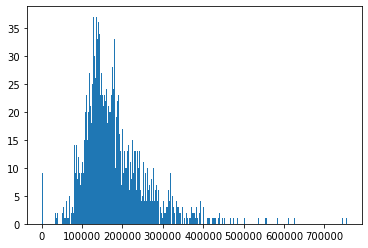

In [113]:
plt.hist(df1['Price'][df1['Price'] < 10**6], bins=300)
plt.show()

In [114]:
d1 = abs( df1.corr(method='pearson')['Price'] ) > 0.3
df1.corr(method='pearson')['Price'].sort_values()

BaseHBath         -0.017661
BaseBath          -0.015135
SaleYear          -0.011036
Fireplaces        -0.005580
HBath             -0.003664
BuildYear         -0.002989
RefurbishYear      0.000521
GarageBuildYear    0.003510
PoolArea           0.003552
Area               0.009381
AGroundBedroom     0.009959
SaleMonth          0.014917
Area2              0.021472
AGroundKitchens    0.023745
GarageCars         0.026587
StreetLength       0.026706
Area1              0.031158
AGroundArea        0.039691
GarageArea         0.049112
Price              1.000000
Name: Price, dtype: float64

In [115]:
d2 = abs( df1[df1['Price'] < 10**6].corr(method='pearson')['Price'] ) > 0.3
df1[df1['Price'] < 10**6].corr(method='pearson')['Price'].sort_values()

AGroundKitchens   -0.132863
BaseHBath         -0.013094
SaleYear          -0.010351
SaleMonth          0.045404
PoolArea           0.092706
AGroundBedroom     0.165552
BaseBath           0.224463
Area               0.261678
HBath              0.272923
Area2              0.312541
StreetLength       0.327523
GarageCars         0.378830
GarageBuildYear    0.431854
Fireplaces         0.458206
RefurbishYear      0.497906
BuildYear          0.513741
Area1              0.601932
GarageArea         0.613481
AGroundArea        0.698660
Price              1.000000
Name: Price, dtype: float64

In [116]:
d3 = ( df1.corr(method='kendall')['Price'] ) > 0.3
df1.corr(method='kendall')['Price'].sort_values()

AGroundKitchens   -0.129906
BaseHBath         -0.008699
SaleYear          -0.005258
PoolArea           0.047614
SaleMonth          0.049560
BaseBath           0.175718
AGroundBedroom     0.178136
Area2              0.223429
StreetLength       0.259694
HBath              0.265319
Area               0.305793
Fireplaces         0.399103
RefurbishYear      0.401110
Area1              0.406192
GarageBuildYear    0.441548
BuildYear          0.456160
GarageArea         0.466626
AGroundArea        0.528775
GarageCars         0.555017
Price              1.000000
Name: Price, dtype: float64

In [117]:
d4 = ( df1[df1['Price'] < 10**6].corr(method='kendall')['Price'] ) > 0.3
df1[df1['Price'] < 10**6].corr(method='kendall')['Price'].sort_values()

AGroundKitchens   -0.135047
BaseHBath         -0.007082
SaleYear          -0.004446
PoolArea           0.048440
SaleMonth          0.049257
BaseBath           0.181085
AGroundBedroom     0.181434
Area2              0.226215
StreetLength       0.262101
HBath              0.270997
Area               0.310559
Fireplaces         0.407951
RefurbishYear      0.408134
Area1              0.411924
GarageBuildYear    0.449920
BuildYear          0.465722
GarageArea         0.472175
AGroundArea        0.536252
GarageCars         0.562114
Price              1.000000
Name: Price, dtype: float64

In [118]:
d5 = ( df1.corr(method='spearman')['Price'] ) > 0.3
df1.corr(method='spearman')['Price'].sort_values()

AGroundKitchens   -0.158949
BaseHBath         -0.010644
SaleYear          -0.008373
PoolArea           0.058226
SaleMonth          0.069764
BaseBath           0.215964
AGroundBedroom     0.225480
Area2              0.283055
HBath              0.326611
StreetLength       0.365186
Area               0.444238
Fireplaces         0.501645
RefurbishYear      0.553233
Area1              0.567763
GarageBuildYear    0.612672
BuildYear          0.630757
GarageArea         0.634437
GarageCars         0.671391
AGroundArea        0.710846
Price              1.000000
Name: Price, dtype: float64

In [119]:
d6 = ( df1[df1['Price'] < 10**6].corr(method='spearman')['Price'] ) > 0.3
df1[df1['Price'] < 10**6].corr(method='spearman')['Price'].sort_values()

AGroundKitchens   -0.165232
BaseHBath         -0.008665
SaleYear          -0.007233
PoolArea           0.059236
SaleMonth          0.069282
BaseBath           0.222565
AGroundBedroom     0.229716
Area2              0.286713
HBath              0.333577
StreetLength       0.368496
Area               0.451254
Fireplaces         0.512834
RefurbishYear      0.563532
Area1              0.575364
GarageBuildYear    0.624936
GarageArea         0.642495
BuildYear          0.644684
GarageCars         0.680356
AGroundArea        0.721458
Price              1.000000
Name: Price, dtype: float64

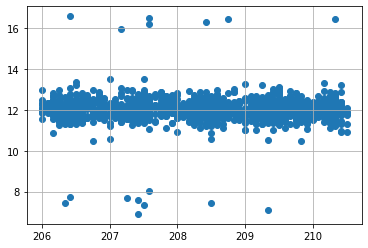

In [120]:
"""
    is property slightly cheaper with time ? what is the appearance of the relationship ?
    
        is financial crisis of 2008 a factor ?  / What if time series were longer?
"""
import numpy as np

plt.scatter(df1['SaleYear'], np.log(df1['Price']))
plt.grid()

In [121]:
set(d2.index[d2 == True]) & \
set(d3.index[d3 == True]) & \
set(d4.index[d4 == True]) & \
set(d5.index[d5 == True]) & \
set(d6.index[d6 == True])

{'AGroundArea',
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'Price',
 'RefurbishYear'}

In [122]:
set(d2.index[d2 == True]) & \
set(d4.index[d4 == True]) & \
set(d6.index[d6 == True])

{'AGroundArea',
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'Price',
 'RefurbishYear'}

In [123]:
set(d4.index[d4 == True]) & \
set(d6.index[d6 == True])

{'AGroundArea',
 'Area',
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'Price',
 'RefurbishYear'}

In [124]:
# Above:  Shows the top correlations

""" REVISITING FOR FEATURE SELECTION

    % nan (from initial processing)

-( NA df1 )

AlleyType       93.767123
GarageType       5.547945
PoolQuality     99.520548
FenceQuality    80.753425

-( NA df2 )

BaseCondition        2.534247
GarageFinish         5.547945
FireplaceQuality    47.260274
BaseHeight           2.534247
GarageCondition      5.547945
OtherFeature        96.301370

-( not NA df1 )

VeneerType     0.547945 (None)
Electrical    32.397260
RoofMat       39.383562

-( not NA df2 )

Electrical    19.657534
County         1.164384
RoofMat       39.589041

-( df1 num )

StreetLength       17.739726
GarageBuildYear     5.547945


    - Do: remove low var columns: AlleyType, PoolQuality, FenceQuality, (confirming)
        
        But: FireplaceQuality? ( thresholds: what is too many 'NA' / high original nan % )
    
    - OtherFeature is connected to FeaturePrice which might be a dependent variable ,
    
        i.e., must be selective with data.


    SUMMARY (so far)

    - Keep: GarageType, GarageFinish, BaseHeight, GarageCondition (has 'NA' and replaced nan)
    -  : Electrical (has "Mix" for mixed), RoofMat (new category for 'UNKNOWN')
    -  : County (small % missing)
    -  : StreetLength (imputed with Median) , GarageBuildYear (0) OK


    PREDICTIVE corr > 0.3 both Rank and Linear (numerical)
    {'AGroundArea',
     'Area1',
     'BuildYear',
     'Fireplaces',
     'GarageArea',
     'GarageBuildYear',
     'GarageCars',
     'Price',
     'RefurbishYear'}
     
    Investigate categorical...  UNIVARIATE FEATURE SELECTION TECHNIQUES
    
    FYI, nan is automatically "ignored" in many Scikit Learn methods

"""
odf1.columns  # RECALL (also gauging length)

Index(['BuildType', 'Electrical', 'ExteriorCondition', 'AlleyType', 'RoofType',
       'RoofMat', 'Style', 'DriveSurface', 'Foundation', 'SaleType',
       'HeatingType', 'PoolQuality', 'AC', 'GarageType', 'VeneerType',
       'FenceQuality', 'Feature1', 'Functionality', 'KitchenQuality', 'Shape',
       'Type'],
      dtype='object')

In [125]:
df1['Price'].min(), df1['Price'].max()

(1000.0, 15900000.0)

In [126]:
df1['LogPrice'] = np.log(df1['Price'])

In [127]:
odf1_stats = []
for c in odf1.columns:
    odf1_stats.append(df1.groupby(c)['LogPrice'].mean().sort_values())
    odf1_stats.append(df1.groupby(c)['LogPrice'].min())
    odf1_stats.append(df1.groupby(c)['LogPrice'].max())
    
print(odf1_stats[0].index)
print(odf1_stats[0].index.name)
print(odf1_stats[0].values)
print(odf1_stats[0].name)

Index(['180', '30', '45', '160', '190', '70', '50', '90', '40', '85', '80',
       '20', '75', '120', '60'],
      dtype='object', name='BuildType')
BuildType
[11.50174966 11.56729214 11.57903298 11.73409255 11.73485314 11.8105391
 11.84651692 11.86948103 11.87042235 11.89586646 12.02182468 12.05036827
 12.06477991 12.17115882 12.29371743]
LogPrice


In [128]:
print(odf1_stats[0].index[0], odf1_stats[0][0])

180 11.501749658839918


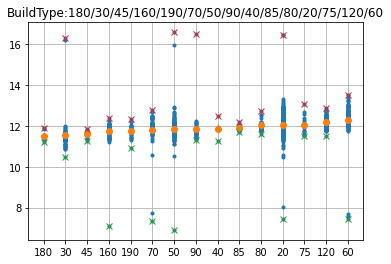

In [129]:
L0 = len(odf1_stats[0])
N0 = odf1_stats[0].index.name
S0 = df1[[N0, 'LogPrice']].set_index(N0).loc[odf1_stats[0].index]
plt.plot(S0.index, S0.values, '.',
         range(L0), odf1_stats[0].values, 'o',
         range(L0), odf1_stats[1].reindex(odf1_stats[0].index).values, 'x',
         range(L0), odf1_stats[2].reindex(odf1_stats[0].index).values, 'x')
plt.grid()
plt.title(odf1_stats[0].index.name + ':' + '/'.join(odf1_stats[0].index))
plt.show()

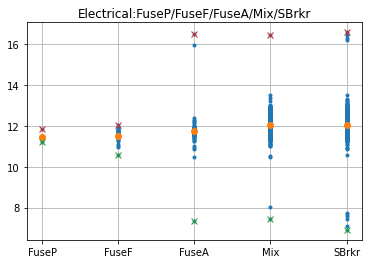

In [130]:
L1 = len(odf1_stats[3])
N1 = odf1_stats[3].index.name
S1 = df1[[N1, 'LogPrice']].set_index(N1).loc[odf1_stats[3].index]
plt.plot(S1.index, S1.values, '.',
         range(L1), odf1_stats[3].values, 'o',
         range(L1), odf1_stats[4].reindex(odf1_stats[3].index).values, 'x',
         range(L1), odf1_stats[5].reindex(odf1_stats[3].index).values, 'x')
plt.grid()
plt.title(odf1_stats[3].index.name + ':' + '/'.join(odf1_stats[3].index))
plt.show()

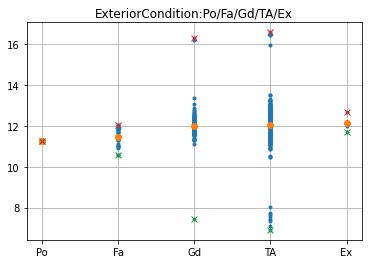

In [131]:
L2 = len(odf1_stats[6])
N2 = odf1_stats[6].index.name
S2 = df1[[N2, 'LogPrice']].set_index(N2).loc[odf1_stats[6].index]
plt.plot(S2.index, S2.values, '.',
         range(L2), odf1_stats[6].values, 'o',
         range(L2), odf1_stats[7].reindex(odf1_stats[6].index).values, 'x',
         range(L2), odf1_stats[8].reindex(odf1_stats[6].index).values, 'x')
plt.grid()
plt.title(odf1_stats[6].index.name + ':' + '/'.join(odf1_stats[6].index))
plt.show()

In [132]:
len(odf1_stats)

63

In [133]:
"""
    Plots, etc.
"""

"""
    (APPENDIX SECTION) REDO CORR WITH LOG (EVEN THOUGH LOG(X) is MONOTONIC INCREASING) -
    
        Min. Price is 1000 > 0, so no worries that -inf. (otherwise do log(1+ x)).
"""

d11 = ( df1.corr(method='pearson')['LogPrice'] ) > 0.3
df1.corr(method='pearson')['LogPrice'].sort_values()

AGroundKitchens   -0.071457
BaseHBath         -0.000208
SaleYear           0.002542
SaleMonth          0.045602
PoolArea           0.046375
AGroundBedroom     0.123384
BaseBath           0.150502
Area               0.165507
HBath              0.169506
Area2              0.182087
StreetLength       0.216698
GarageCars         0.264394
Fireplaces         0.288723
GarageBuildYear    0.310176
RefurbishYear      0.339964
BuildYear          0.356596
Area1              0.396613
GarageArea         0.414520
AGroundArea        0.439534
Price              0.548781
LogPrice           1.000000
Name: LogPrice, dtype: float64

In [134]:
d12 = abs( df1[df1['Price'] < 10**6].corr(method='pearson')['LogPrice'] ) > 0.3
df1[df1['Price'] < 10**6].corr(method='pearson')['LogPrice'].sort_values()

AGroundKitchens   -0.100866
BaseHBath          0.009271
SaleYear           0.009329
SaleMonth          0.048082
PoolArea           0.055988
AGroundBedroom     0.148290
BaseBath           0.194270
Area               0.198733
HBath              0.213214
Area2              0.214845
StreetLength       0.253422
GarageCars         0.311185
Fireplaces         0.360681
GarageBuildYear    0.380056
RefurbishYear      0.416717
BuildYear          0.440403
Area1              0.470286
GarageArea         0.485607
AGroundArea        0.521181
Price              0.811026
LogPrice           1.000000
Name: LogPrice, dtype: float64

In [135]:
d13 = ( df1.corr(method='kendall')['LogPrice'] ) > 0.3
df1.corr(method='kendall')['LogPrice'].sort_values()

AGroundKitchens   -0.129906
BaseHBath         -0.008699
SaleYear          -0.005258
PoolArea           0.047614
SaleMonth          0.049560
BaseBath           0.175718
AGroundBedroom     0.178136
Area2              0.223429
StreetLength       0.259694
HBath              0.265319
Area               0.305793
Fireplaces         0.399103
RefurbishYear      0.401110
Area1              0.406192
GarageBuildYear    0.441548
BuildYear          0.456160
GarageArea         0.466626
AGroundArea        0.528775
GarageCars         0.555017
Price              1.000000
LogPrice           1.000000
Name: LogPrice, dtype: float64

In [136]:
d14 = ( df1[df1['Price'] < 10**6].corr(method='kendall')['LogPrice'] ) > 0.3
df1[df1['Price'] < 10**6].corr(method='kendall')['LogPrice'].sort_values()

AGroundKitchens   -0.135047
BaseHBath         -0.007082
SaleYear          -0.004446
PoolArea           0.048440
SaleMonth          0.049257
BaseBath           0.181085
AGroundBedroom     0.181434
Area2              0.226215
StreetLength       0.262101
HBath              0.270997
Area               0.310559
Fireplaces         0.407951
RefurbishYear      0.408134
Area1              0.411924
GarageBuildYear    0.449920
BuildYear          0.465722
GarageArea         0.472175
AGroundArea        0.536252
GarageCars         0.562114
Price              1.000000
LogPrice           1.000000
Name: LogPrice, dtype: float64

In [137]:
d15 = ( df1.corr(method='spearman')['LogPrice'] ) > 0.3
df1.corr(method='spearman')['LogPrice'].sort_values()

AGroundKitchens   -0.158949
BaseHBath         -0.010644
SaleYear          -0.008373
PoolArea           0.058226
SaleMonth          0.069764
BaseBath           0.215964
AGroundBedroom     0.225480
Area2              0.283055
HBath              0.326611
StreetLength       0.365186
Area               0.444238
Fireplaces         0.501645
RefurbishYear      0.553233
Area1              0.567763
GarageBuildYear    0.612672
BuildYear          0.630757
GarageArea         0.634437
GarageCars         0.671391
AGroundArea        0.710846
Price              1.000000
LogPrice           1.000000
Name: LogPrice, dtype: float64

In [138]:
d16 = ( df1[df1['Price'] < 10**6].corr(method='spearman')['LogPrice'] ) > 0.3
df1[df1['Price'] < 10**6].corr(method='spearman')['LogPrice'].sort_values()

AGroundKitchens   -0.165232
BaseHBath         -0.008665
SaleYear          -0.007233
PoolArea           0.059236
SaleMonth          0.069282
BaseBath           0.222565
AGroundBedroom     0.229716
Area2              0.286713
HBath              0.333577
StreetLength       0.368496
Area               0.451254
Fireplaces         0.512834
RefurbishYear      0.563532
Area1              0.575364
GarageBuildYear    0.624936
GarageArea         0.642495
BuildYear          0.644684
GarageCars         0.680356
AGroundArea        0.721458
Price              1.000000
LogPrice           1.000000
Name: LogPrice, dtype: float64

In [139]:
"""  In normal (non log) scale

{'AGroundArea',
  ( only in rank correlation highly is 'Area', )
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'Price',
 'RefurbishYear'}

"""

set(d12.index[d12 == True]) & \
set(d13.index[d13 == True]) & \
set(d14.index[d14 == True]) & \
set(d15.index[d15 == True]) & \
set(d16.index[d16 == True])

{'AGroundArea',
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'LogPrice',
 'Price',
 'RefurbishYear'}

In [140]:
set(d12.index[d12 == True]) & \
set(d14.index[d14 == True]) & \
set(d16.index[d16 == True])

{'AGroundArea',
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'LogPrice',
 'Price',
 'RefurbishYear'}

In [141]:
set(d14.index[d14 == True]) & \
set(d16.index[d16 == True])

{'AGroundArea',
 'Area',
 'Area1',
 'BuildYear',
 'Fireplaces',
 'GarageArea',
 'GarageBuildYear',
 'GarageCars',
 'LogPrice',
 'Price',
 'RefurbishYear'}

In [142]:
"""
    continuing "FEATURE SELECTION" for includes CATEGORICAL

"""
y_keys.keys() & set(df1.columns)

{'SaleMonth', 'SaleType', 'SaleYear'}

In [143]:
"""
    (PRE) PROCESSING CATEGORICALS TO BE DISCRETE/ORDINAL VECTOR

"""

for i, s in enumerate(odf1_stats):
    if i%3!=0:
        continue
    df1[s.index.name] = df1[s.index.name].replace(
        dict(zip(s.index.values, range(1, len(s.index.values)+1)))
    )

In [144]:
from sklearn.feature_selection import mutual_info_regression

mi1 = mutual_info_regression( df1.loc[:, df1.columns != 'Price'].to_numpy(), df1['Price'].to_numpy())
mi2 = mutual_info_regression( df1.loc[:, df1.columns != 'LogPrice'].to_numpy(), df1['LogPrice'].to_numpy())

In [145]:
df1.columns

Index(['BuildType', 'Area', 'RefurbishYear', 'Electrical', 'PoolArea',
       'ExteriorCondition', 'Area1', 'GarageCars', 'AlleyType', 'SaleYear',
       'Fireplaces', 'RoofType', 'RoofMat', 'StreetLength', 'Style',
       'DriveSurface', 'Foundation', 'AGroundKitchens', 'SaleType',
       'BuildYear', 'HeatingType', 'PoolQuality', 'AC', 'AGroundBedroom',
       'GarageType', 'VeneerType', 'HBath', 'Area2', 'FenceQuality',
       'Feature1', 'GarageArea', 'SaleMonth', 'Functionality', 'BaseBath',
       'GarageBuildYear', 'KitchenQuality', 'AGroundArea', 'BaseHBath',
       'Shape', 'Type', 'Price', 'LogPrice'],
      dtype='object')

In [146]:
mi1.shape, mi2.shape, df1.shape

((41,), (41,), (1452, 42))

In [147]:
ix1 = sorted(zip(mi1, range(len(mi1))), key = lambda x: -x[0])

In [148]:
ix2 = sorted(zip(mi2, range(len(mi2))), key = lambda x: -x[0])

In [149]:
l1 = list(list(zip(*ix1))[1])
k1 = sum(map(int, list(x[0] > 0.2 for x in ix1)))
print(df1.columns[l1])
print(df1.columns[l1][1:k1])

Index(['Price', 'AGroundArea', 'GarageArea', 'BuildYear', 'GarageCars',
       'Area1', 'KitchenQuality', 'GarageBuildYear', 'BuildType',
       'RefurbishYear', 'StreetLength', 'Area2', 'GarageType', 'Foundation',
       'Area', 'Fireplaces', 'Shape', 'VeneerType', 'Style', 'HBath',
       'AGroundBedroom', 'SaleType', 'AC', 'DriveSurface', 'Electrical',
       'Type', 'AGroundKitchens', 'FenceQuality', 'BaseHBath', 'AlleyType',
       'RoofMat', 'BaseBath', 'PoolArea', 'Feature1', 'Functionality',
       'RoofType', 'ExteriorCondition', 'PoolQuality', 'HeatingType',
       'SaleYear', 'SaleMonth'],
      dtype='object')
Index(['AGroundArea', 'GarageArea', 'BuildYear', 'GarageCars', 'Area1',
       'KitchenQuality', 'GarageBuildYear', 'BuildType', 'RefurbishYear',
       'StreetLength', 'Area2', 'GarageType', 'Foundation'],
      dtype='object')


In [150]:
"""
    {'AGroundArea',
      ( only in rank correlation highly is 'Area', )
     'Area1',
     'BuildYear',
     'Fireplaces',
     'GarageArea',
     'GarageBuildYear',
     'GarageCars',
     'Price',
     'RefurbishYear'}

    'AGroundArea',
    'GarageArea',
    'BuildYear',
    'GarageCars',
    'Area1',
    'KitchenQuality',  # # Categ.
    'GarageBuildYear',
    'BuildType',  # # Categ.
    'RefurbishYear',
    'StreetLength',  # Numer. (not included previously..)
    'Area2',  #       Numer. (not included previously..)
    'GarageType',  # # Categ.
    'Foundation'  # # Categ.

"""
5

5

In [151]:
l2 = list(list(zip(*ix2))[1])
k2 = sum(map(int, list(x[0] > 0.2 for x in ix2)))
print(df1.columns[l2])
print(df1.columns[l2][1:k2])

Index(['Price', 'AGroundArea', 'GarageArea', 'BuildYear', 'GarageCars',
       'Area1', 'KitchenQuality', 'GarageBuildYear', 'BuildType',
       'RefurbishYear', 'StreetLength', 'GarageType', 'Area2', 'Foundation',
       'Area', 'Fireplaces', 'VeneerType', 'Shape', 'HBath', 'Style',
       'AGroundBedroom', 'SaleType', 'AC', 'Type', 'DriveSurface',
       'FenceQuality', 'Electrical', 'AlleyType', 'Feature1', 'BaseBath',
       'ExteriorCondition', 'AGroundKitchens', 'BaseHBath', 'HeatingType',
       'Functionality', 'RoofMat', 'PoolQuality', 'PoolArea', 'SaleYear',
       'RoofType', 'SaleMonth'],
      dtype='object')
Index(['AGroundArea', 'GarageArea', 'BuildYear', 'GarageCars', 'Area1',
       'KitchenQuality', 'GarageBuildYear', 'BuildType', 'RefurbishYear',
       'StreetLength', 'GarageType'],
      dtype='object')


In [152]:
"""
    'AGroundArea',
    'GarageCars',
    'GarageArea',
    'BuildYear',
    'Area1',
    'KitchenQuality',  # # Categ.
    'GarageBuildYear',
    'BuildType',  # # Categ.
    'RefurbishYear',
    'StreetLength',  # Numer. (not included previously..)
    'Area2',  #       Numer. (not included previously..)
    'GarageType'  # # Categ.
      ## ('Foundation' - categorical - not included)

    We can build (the linear regression) predictive model for either price / log price using these
"""
0

0

In [153]:
df1['Foundation'].value_counts()

6    639
3    634
2    146
1     24
4      6
5      3
Name: Foundation, dtype: int64

In [154]:
keys['Foundation'], values['Foundation']

('Type of foundation',
 [('BrkTil', 'Brick & Tile'),
  ('CBlock', 'Cinder Block'),
  ('PConc', 'Poured Contrete'),
  ('Slab', 'Slab'),
  ('Stone', 'Stone'),
  ('Wood', 'Wood')])

In [155]:
# WHAT IF JUST CATEG

oi1 = mutual_info_regression( df1[odf1.columns].to_numpy(), df1['Price'].to_numpy())
oi2 = mutual_info_regression( df1[odf1.columns].to_numpy(), df1['LogPrice'].to_numpy())

In [156]:
oix1 = sorted(zip(oi1, range(len(oi1))), key = lambda x: -x[0])

In [157]:
oix2 = sorted(zip(oi2, range(len(oi2))), key = lambda x: -x[0])

In [158]:
ol1 = list(list(zip(*oix1))[1])
ok1 = sum(map(int, list(x[0] > 0.15 for x in oix1)))
print(odf1.columns[ol1])
print(odf1.columns[ol1][:ok1])

Index(['KitchenQuality', 'GarageType', 'Foundation', 'BuildType', 'VeneerType',
       'Shape', 'AC', 'SaleType', 'DriveSurface', 'Style', 'Type',
       'FenceQuality', 'Electrical', 'AlleyType', 'Feature1',
       'ExteriorCondition', 'RoofType', 'RoofMat', 'HeatingType',
       'Functionality', 'PoolQuality'],
      dtype='object')
Index(['KitchenQuality', 'GarageType', 'Foundation', 'BuildType'], dtype='object')


In [159]:
ol2 = list(list(zip(*oix2))[1])
ok2 = sum(map(int, list(x[0] > 0.15 for x in oix2)))
print(odf1.columns[ol2])
print(odf1.columns[ol2][:ok2])

Index(['KitchenQuality', 'GarageType', 'Foundation', 'BuildType', 'VeneerType',
       'Shape', 'SaleType', 'AC', 'Style', 'DriveSurface', 'Type',
       'FenceQuality', 'Electrical', 'AlleyType', 'Feature1', 'RoofMat',
       'ExteriorCondition', 'Functionality', 'HeatingType', 'PoolQuality',
       'RoofType'],
      dtype='object')
Index(['KitchenQuality', 'GarageType', 'Foundation', 'BuildType'], dtype='object')


In [160]:
"""
    Just making sure ( Also, not the low var / many missing :  AlleyType, PoolQuality, FenceQuality, )
    
"""
odf1.columns

Index(['BuildType', 'Electrical', 'ExteriorCondition', 'AlleyType', 'RoofType',
       'RoofMat', 'Style', 'DriveSurface', 'Foundation', 'SaleType',
       'HeatingType', 'PoolQuality', 'AC', 'GarageType', 'VeneerType',
       'FenceQuality', 'Feature1', 'Functionality', 'KitchenQuality', 'Shape',
       'Type'],
      dtype='object')

In [161]:
newdf1.columns

Index(['Area', 'RefurbishYear', 'PoolArea', 'Area1', 'GarageCars', 'SaleYear',
       'Fireplaces', 'StreetLength', 'AGroundKitchens', 'BuildYear',
       'AGroundBedroom', 'HBath', 'Area2', 'GarageArea', 'SaleMonth',
       'BaseBath', 'GarageBuildYear', 'AGroundArea', 'BaseHBath', 'Price'],
      dtype='object')

In [162]:
set(df1.columns) - set(newdf1.columns) - set(odf1.columns)

{'LogPrice'}

In [163]:
"""
    BUILD A SALES PRICE ESTIMATION MODEL WITH:

    'Area',
    'Area1',
    'Area2',

    'AGroundArea',

    'GarageArea',
    'GarageCars',
    'GarageBuildYear',
    
    'BuildYear',
    
    'RefurbishYear',

    'StreetLength',
    
    'KitchenQuality',
    'GarageType',
    'Foundation',
    'BuildType',
    
    VERY IMPORTANT CONSIRATION:  (must look at mixed effects models)

    'SaleType': [('WD', 'Warranty Deed - Conventional'),
              ('CWD', 'Warranty Deed - Cash'),
              ('VWD', 'Warranty Deed - VA Loan'),
              ('New', 'Home just constructed and sold'),
              ('COD', 'Court Officer Deed/Estate'),
              ('Con', 'Contract 15% Down payment regular terms'),
              ('ConLw', 'Contract Low Down payment and low interest'),
              ('ConLI', 'Contract Low Interest'),
              ('ConLD', 'Contract Low Down'),
              ('Oth', 'Other')],
"""
0

0

In [164]:
COL = {
    'Area',
    'Area1',
    'Area2',
    'AGroundArea',
    'GarageArea',
    'GarageCars',
    'GarageBuildYear',
    'BuildYear',
    'RefurbishYear',
    'StreetLength',
    'KitchenQuality',
    'GarageType',
    'Foundation',
    'BuildType'
}

In [165]:
df1.to_csv('train_1_clean.csv')

In [166]:
"""
    DISCUSSION:
        -> take no shortcuts
        -> generated ranks to use for categorical data OK
            -> but for PCA, categorical rank is/not in linear relationship with price
            -> wanted to use FAMD (error in R code is that need convert back to categorical at least >= 2 COL [?])

        -> did not finish plotting in python (use subplots in simple for loop to end up with 41 plots)
        => it looks like Quantile Regression would be useful to model Linear univariates relations
            -> Linear (mixed categorical) multiple univariates relations against continuous target / prediction
            
        -> Explained variance in data / explanatory variables -> most informative, Factor Decomposition / Signal
        -> corr (correlations) miss some positive relationships like "  VeneerType  " which explains
            more variance (%) than StreetLength and Area2 and Area ! (in that order)
            
            > Also LogPrice is important/pairs of correlations may form "non lin." relat* to output > selector

        -> instead of assigning integer ranks to express actual categories, split into multiple columns for yes/no
            -> booleans / binary. But then many horizontally columns 
                -> 151 COLUMNS TOTAL (then do "low rank matrix"-appropriate regression)


    From R Script:

sort(res.pca$var$contrib[,1])
        BaseHBath          SaleYear                 X 
     0.0008583478      0.0021109460      0.0146248079 
          RoofMat         SaleMonth             Price 
     0.0315653634      0.0384788967      0.0934955522 
         PoolArea       PoolQuality    AGroundBedroom 
     0.1384851578      0.1425627573      0.2888498594 
    Functionality          RoofType          BaseBath 
     0.2919892770      0.4541173914      0.5804855412 
     
     FenceQuality   AGroundKitchens              Area 
     0.5812899260      0.6347664719      0.6405751932 
             Type          Feature1 ExteriorCondition 
     0.6978201170      0.7775865759      0.8440281724 
     
      HeatingType         AlleyType             Area2 
     0.8724387244      0.8902881129      0.9131783926 
       Electrical             Shape             HBath 
     0.9854021853      1.4022940782      1.6732728626 
     
     StreetLength             Style          SaleType 
     1.8189820907      1.9600699257      1.9867460332 
       Fireplaces      DriveSurface                AC 
     2.5680558284      2.6119696495      2.7290166175 
     
       VeneerType        GarageCars             Area1 
     3.3238474139      3.5167851782      3.8483333327 
         LogPrice       AGroundArea     RefurbishYear 
     4.6855374018      4.8337799267      5.3836103576 
       Foundation         BuildType    KitchenQuality 
     5.7246775393      6.3796005942      6.5298149961 
  GarageBuildYear        GarageType        GarageArea 
     6.9450961065      7.0445736893      7.2500450861 
        BuildYear 
     7.8688935221 
"""
sum(len(values[key]) for key in values if key in set(odf1.columns)), newdf1.columns.shape

(131, (20,))

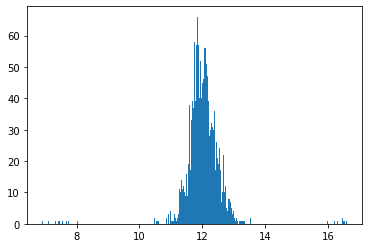

In [167]:
plt.hist(df1['LogPrice'], bins=300)
plt.show()

In [168]:
reverse = ['BuildYear', 'GarageArea', 'GarageType', 'GarageBuildYear', 'KitchenQuality', 'BuildType',
          'Foundation', 'RefurbishYear', 'AGroundArea', 'Area1', 'GarageCars', 'VeneerType']
LEN = len(reverse)
print(LEN)

12


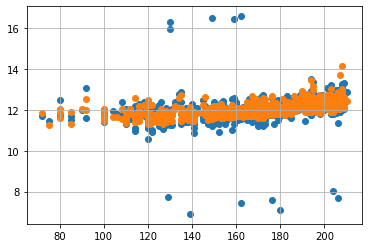

In [169]:
from sklearn.linear_model import TheilSenRegressor, QuantileRegressor

j = 1000
qr = TheilSenRegressor()  # QuantileRegressor(quantile=0.5) OR ADD THE PRINCIPAL COMPONENTS
X = df1[['BuildYear', 'AGroundArea']][:j]
y = df1['LogPrice'][:j]
qr.fit(X, y)
plt.scatter(X['BuildYear'], y)
plt.scatter(X['BuildYear'].to_numpy(), qr.predict(X))
plt.grid()
plt.show()